In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.preprocessing import ScalerWrapper
from darts.metrics import mape, r2_score
from darts.utils.missing_values import auto_fillna

In [3]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

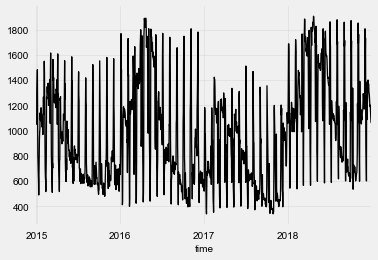

In [7]:
df = pd.read_csv('energy_dataset.csv', delimiter=",")
df['time'] = pd.to_datetime(df['time'], utc=True)
df['time']= df.time.dt.tz_localize(None)
df_day_avg = df.groupby(df['time'].astype(str).str.split(" ").str[0]).mean().reset_index()
series = auto_fillna(TimeSeries.from_dataframe(df_day_avg, 'time', ['generation hydro run-of-river and poundage']))
series.plot()

In [11]:
train, val = series.split_after(pd.Timestamp('20170901'))

### General model

In [16]:
model_nbeats = NBEATSModel(
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    input_length=30,
    output_length=7,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800
)

In [17]:
model_nbeats.fit(
    training_series=train,
    val_training_series=val,
    verbose=True
)

Training loss: 55427.9004, validation loss: 71580.1328366


[2020-10-12 17:44:16,090] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


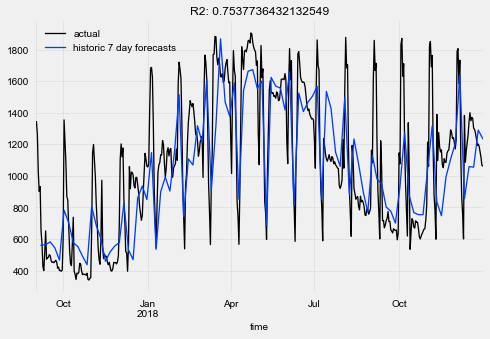

In [18]:
pred_series = model_nbeats.backtest(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    use_full_output_length=True,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))

### Interpretable model

In [20]:
model_nbeats = NBEATSModel(
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    input_length=30,
    output_length=7,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800
)

../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [21]:
model_nbeats.fit(
    training_series=train,
    val_training_series=val,
    verbose=True
)

Training loss: 117696.7266, validation loss: 113233.76950


[2020-10-12 17:50:07,160] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.


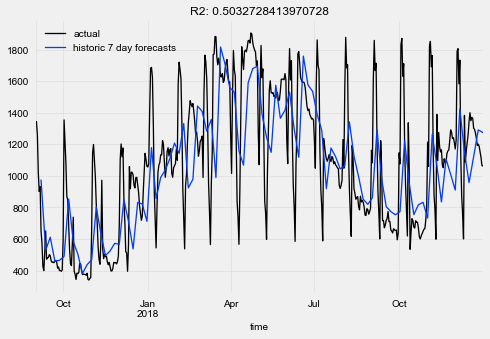

In [22]:
pred_series = model_nbeats.backtest(
    series,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    use_full_output_length=True,
    verbose=True
)
display_forecast(pred_series, series['0'], '7 day', start_date=pd.Timestamp('20170901'))